# **Predicting Restaurant Closure With Yelp**

Jiwon Kim (jk5804), Tina Krulec(kk3506), Simran Parwani(sp4494)\*  


DS-GA Introduction to Machine Learning   
**responsible for team submissions* 

## **Introduction** 

**Description of Problem**    
Restaurant owners make significant time and financial investment in opening a restaurant. It is thus important for restaurant owners to understand what factors contribute to successful restaurants so that they are able to make sound financial and business decisions before making these investments. In our project, we aim to explore whether we can predict whether a restaurant will close in order to understand what factors prospective restaurant owners should consider before opening a restaurant.


**Motivation**   
It has become increasingly hard for restaurants to remain open only with the profit generated by in-house guests, due to a very new phenomenon of food delivery and home meal prep services. We hope to help prospective restaurant owners to efficiently prepare for entering the restaurant industry by giving them a list of parameters they should consider. Similar experiments have been done before relying on natural language processing methods like sentiment analysis of reviews. However, we hope to experiment using the models we have learned about in class and hope to create other features beyond analyzing the text of reviews.

A very similar methodology can be applied to a wide variety of different businesses. Trends of what makes a business a successful one change constantly, however, the model we are proposing should be able to assign weights to specific parameters and predict whether the business will remain open despite the market fluctuations. Looking at the big picture, it is very important for investors and owners to follow those trends and be able to prepare on how to deal with shortcomings and leverage their strengths. 


**References**    
Mejia, Jorge & Mankad, S. & Gopal, A.. (2015). "More Than Just Words: Latent Semantic Analysis, Online Reviews and Restaurant Closure". Academy of Management Proceedings. 2015. 13912-13912. 10.5465/AMBPP.2015.13912abstract. 

This paper predicts whether a restaurant closed using the linguistic patterns of the reviews and shows that the restaurants with reviews of more negatively associated words are likely to close than its contrary.    

Although the influence of reviews is undeniable in determining the success or failure of a restaurant, rather than narrowing the model to just reviews, our model utilizes other features such as restaurant density, number of competitors and more along with the ratings to approach the problem in a various perspectives and to look at different components that determine the success or failure of a restaurant.


# **Model**

**Tools**   
•  NTLK for sentiment analysis of reviews   
•  Numpy and pandas for data processing   
•  Sci-kit learn for model training and evaluation and feature creation     
•  Pickle for saving large datasets and sharing dataframes    
•  Matplotlib for visualizing model results

**Methodology**     

After creating our features, we converted categorical features using one-hot encoding and numerical features using max-min normalization. We filled in missing numerical values using the mean of that feature.

We separated our data into 80% training and 20% test and used the attribute ‘is_closed’ as our prediction variable.

We used the following models to train our data: Linear SVC, Perceptron, and Random Forest. We then hypertuned parameters using 5 fold cross-validation and selected the most accurate model.   

    
     
Step 1: Cleaning Data   
__

Since the Yelp dataset contains data from all businesses and our analysis focuses on restaurants, we filtered the dataset using the categories attribute to remove non-restaurant businesses. Additionally, since there were discrepancies in some of the data points for international businesses and considering the differing cultures and laws and societal norms surrounding owning a business in different countries, we only used data from the US to remove the influence of extraneous variables and keep data consistent. The reason why we chose the US instead of another country represented in the dataset was that the three other countries had limited amounts of data compared to what we had for the US. Thus, in order to have enough training data, we selected restaurants that were in the US.   


In [0]:
#converting json to pickles to share with team members and reduce loading times
import pandas as pd
import numpy as np

df1=pd.read_json('business.json',lines=True)
df1.to_pickle('business.pickle')

df2=pd.read_json('review.json',lines=True)
df2.to_pickle('review.pickle')

df3=pd.read_json('checkin.json',lines=True)
df3.to_pickle('checkin.pickle')

In [0]:
# drop unnecessary columns from the database
cleanBus = business.drop(['address','latitude','longitude','hours'], axis=1)

# select only the US businesses by sorting through the postal code
postalCodes = cleanBus.postal_code.unique()
US = [] 
nonUS = []
for x in postalCodes:
    if x.isnumeric(): # US - 5 digits
        US.append((x))
    else:
        nonUS.append(x)# nonUS - mix of letters and numbers
#drop businesses with nonUS postal codes
for x in nonUS:
    cleanBus.drop(cleanBus[cleanBus['postal_code'] == x].index , inplace=True)

# sort through to drop any businesses that are not restaurants
cleanBus.loc[cleanBus.categories.notnull()]
restaurantSort = cleanBus['categories'].str.contains('Restaurants',na=False)
restaurants = cleanBus[restaurantSort]

# saves the dataframe into a pickle
restaurants.to_pickle("restaurant.pkl")


# read from the databases

business = pd.read_pickle('business.pickle')
restaurants = pd.read_pickle("restaurant.pkl")

# list of business ID's of all businesses
businessList = business.business_id.unique()

# list of business ID's of restaurants
restaurantList = restaurants.business_id.unique()

# list of business ID's of non-restaurants
nonRestList = []
for i in businessList:
    if (i not in restaurantList):
        nonRestList.append(i)
        
# read from the database
checkin = pd.read_pickle('checkin.pickle')


# takes really long time 
# goes through the non restaurant businesses list and drops them from the checkin dataframe.
for x in nonRestList:
    checkin.drop(checkin[checkin['business_id'] == x].index , inplace=True)
    
# saves the dataframe into a pickle
checkin.to_pickle("restaurantCheckin.pkl")


# save the buiness id lists into txt files
with open("nonRestaurantBusinessList.txt", "w") as output:
    output.write(str(nonRestList))
    
with open("restaurantBusinessList.txt", "w") as output:
    for i in restaurantList:
        print(i)
        output.write(str(i)+'')

with open("businessList.txt", "w") as output:
    for i in businessList:
        output.write(str(i)+'\n')



In [0]:
#create list of restaurants
textData = pd.read_csv('/content/drive/My Drive/MachineLearningFinalProject/clean data/restaurantBusinessList.txt', header=None)
restaurants=textData[0].tolist()

#filters review data to include data in the list of restaurants (filters out non-restaurant businesses)
filtered = pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/review.pickle')
new_df = filtered[filtered['business_id'].isin(restaurants)]

#split review data into 10 so it can be processed else program runs out of RAM
split = np.array_split(new_df,10)
for i in range(10):
  print(i)
  split[i].to_pickle('/content/drive/My Drive/MachineLearningFinalProject/review'+str(i)+'.pkl', compression ='gzip')

#creates data of all split data
reviews=[]
for i in range(10):
  print(i)
  data=pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/review'+str(i)+'.pkl',compression='gzip')
  reviews.append(data)
all_data = pd.concat(reviews)

Step 2: Feature Engineering   
__

One of the things we were most excited about for this project was the potential for feature engineering. Though the Yelp dataset has limited already created features, it offers a lot of possibility for exploration.   

In summary, our features include:    
•  Age: date of first review to Dec 2018   
•  Restaurant Density: number of other restaurants within same postal code    
•  Popularity: average number of reviews per week    
•  Satisfaction: linear regression of star rating (out of 5 stars) over time    
•  Chain: true if restaurant is a chain    
•  Review sentiment over time: linear regression of compound sentiment    
•  Category    
•  Number of categories    
•  City    
•  Average star rating     



In [0]:
#Linear regression for finding the sentiment analysis over time or the star rating over time

from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr_text= LinearRegression()
regr_reviews = LinearRegression()

#using nltk for sentiment analysis of reviews
import nltk
nltk.download('vader_lexicon')

#using compound score which is a summary of positive, negative, neutral
def sentiment_analysis(text):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sent = SentimentIntensityAnalyzer()
    score = sent.polarity_scores(text)
    return score['compound']

In [0]:
#creates a timestamp of the end of december 2018 to calculate the age
end_date=pd.Timestamp('2018-12-31T23:59:59') 
review_data = []
for id in restaurants:
  #creates a temp dataframe of all review entries of a specific id
  temp = all_data[all_data['business_id']==id]
  #age in weeks
  age = (end_date-min(temp['date'])).days/7
  #converts dates to integers for linear regression
  dates = [d.toordinal() for d in temp['date']]
  dates = np.asarray(dates)
  regr.fit(dates.reshape(-1,1),temp ['stars'].values.reshape(-1,1))
  #calculates the coefficient which is an indicator of the trend over time
  star_trend = regr.coef_[0][0]
  #creates a list with all the reviews
  text_list = temp['text'].tolist()
  review_scores=[]
  #calculates sentiment analysis of each review text
  for review in text_list:
    review_scores.append(sentiment_analysis(review))
  review_scores=np.asarray(review_scores)
  #finds sentiment over time
  regr_text.fit(dates.reshape(-1,1),review_scores.reshape(-1,1))
  sent_trend=regr_text.coef_[0][0]
  #calculates average reviews over the number of weeks
  avg_reviews = len(text_list)/age
  review_data.append([id,age,star_trend,sent_trend,avg_reviews])

In [0]:
#creates pickle of feature data 
review_features=[]
for i in range(1,13):
  print(i)
  temp=pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/Feature Data/data'+str(i)+'.pkl',compression='gzip')
  review_features.append(temp)
feature_data = pd.concat(review_features)

In [0]:
# the unique list of restaurants 
name = restaurants.name.unique()
# general list of restaurants
nameList = restaurants.name

# density
# postal code general list 
postal_code = np.array(restaurants.postal_code)
# postal code unique list
postalCodeList = restaurants.postal_code.unique()

# group restaurants according to its postal codes
postalCodeSorted = []
for pc in postalCodeList:
    postalCodeSorted.append(restaurants[restaurants['postal_code']==pc])

# create a dictionary that shows how many restaurants are in the postal code
densityCount = {}
for i in range(len(postalCodeList)):
    densityCount[postalCodeList[i]]=len(postalCodeSorted[i])
    
# connect restaurants to counters
counter = []
for pc in postal_code:
    counter.append(densityCount[pc])

# is_chain
# list of chain restaurants
chain = []
for n in name:
    if (len(restaurants[restaurants['name']==n])>2):
        chain.append(n)
        
chainCheck = []
for n in nameList: 
    if (n in chain):
        chainCheck.append(1)
    else:
        chainCheck.append(0)
        
# add y; is_open
openCheck = restaurants.is_open
is_open=[]
for i in openCheck:
    is_open.append(int(i))
    
    
features = pd.DataFrame(business_id,columns=['business_id'])
features['postal_code'] = postal_code
#counter is the restaurant density by postal code
features['counter'] = counter
features['is_chain'] = chainCheck
features['is_open'] = is_open


features.to_pickle("densityANDchain.pkl")

In [0]:
#merging various feature pickles together 
feature_data.to_pickle('/content/drive/My Drive/MachineLearningFinalProject/review_feature.pkl')

feature_data['business_id']=feature_data['id']

feature_data=feature_data.drop(['id'], axis=1)

density = pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/densityANDchain.pkl')

#join on business id as primary key
df_merged = pd.merge(feature_data,density,on='business_id')

new_merged=df_merged[df_merged['age']>0]

new_merged.to_pickle('/content/drive/My Drive/MachineLearningFinalProject/feature_dataframe.pkl')

new_merged =pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/feature_dataframe.pkl')

In [0]:
business_data = pd.read_pickle('/content/drive/My Drive/MachineLearningFinalProject/clean data/restaurant.pkl')
#creates features using business attribute data
category_cnt=[]
for index, row in business_data.iterrows():
  #counts the number of categories listed
  temp=(row['categories']).split(' ')
  #creates a new list with the business id, the avg_star rating, and the number of categories
  category_cnt.append([row['business_id'],row['stars'],len(temp)])
#adds new features to dataframe
category_cnt = pd.DataFrame(category_cnt, columns=['business_id','avg_stars','number_of_categories'])
temp = pd.merge(category_cnt, new_merged,on='business_id')

Step 3:   
Feature Vectorization and Max-Min Normalization .  
__

The next step was to prepare our feature vector to use with the models. To do this, we needed to convert categorical features through one-hot encoding and normalize certain numerical features.


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

#function that vectorizes features using Scikit-learn
def feature_vectorization(column, index):
    vectorizer = CountVectorizer()
    vectorized_words = vectorizer.fit_transform(column)
    all_words = vectorizer.get_feature_names()
    df_words = pd.DataFrame(vectorized_words.toarray(), index=index, columns= all_words)
    return df_words

#creates dummy variables for cities
cities = feature_vectorization(business_data['city'], business_data['business_id'])
cities=cities.reset_index()

#creates dummy variables for categories
#only uses categories that are in Yelp documentation as restaurant categories
#many restuarants were also classified as 'dentist' 'bowling' etc.
cat=pd.read_csv('/content/drive/My Drive/MachineLearningFinalProject/categories.txt',header=None, names=['category_name'])
category_list=[]
for row in cat.iterrows():
  print(row[1]['category_name'])
  name = row[1]['category_name']
  name= name.split(' ')
  category_list.append(name[0].lower())
temp3=pd.DataFrame()
categories = feature_vectorization(business_data['categories'], business_data['business_id'])
temp_list=categories.columns.tolist()
for col in temp_list:
  if col in category_list:
    temp3[col]=categories[col]


In [0]:
#merges dataframe with new category and city dummy variables
with_cities = pd.merge(cities, temp,on='business_id')
with_cat=pd.merge(temp3,with_cities,on='business_id')
#drops postal code column
with_cat=with_cat.drop(['postal_code'],axis=1)
#creates final pickle with all the features
with_cat.to_pickle('/content/drive/My Drive/MachineLearningFinalProject/tinaspickle.pkl')

In [0]:
#USING MIN MAX NORMALIZATION TO NORMALIZE 'bigger' numerican values
#dataframe was loaded using pickle and named df
to_normalize=['age','avg_stars', 'number_of_categories', 'star_trend', 'sent_trend','counter']

for i in to_normalize:
    new=[]
    max_value = df[i].max()
    min_value = df[i].min()
    for j in range(len(df)):
        new.append((df[i][j] - min_value) / (max_value - min_value))
    df[i]=new

y=df['is_open']
dataframe=df.drop('is_open', axis=1)
dataframe.drop('business_id', axis=1, inplace=True)
features=dataframe.columns
X=dataframe.values

#  **Experiments**

**Dataset**    
We will be using the Yelp Academic Dataset released on January 15, 2019, containing information about businesses up to 2018. The dataset contains information from 11 metropolitan cities spanning four countries: Edinburgh (UK), Stuttgart (Germany), Montreal (Canada), Toronto (Canada), Pittsburgh, Charlotte, Champaign-Urbana, Phoenix, Las Vegas, Madison, and Cleveland. The original dataset consists of six JSON files of about 9 GB in total size. We will be specifically using three json files, business, check-ins, and reviews, and creating a merged dataset using the business id as a key. 

**Algorithm and Explanation of Results**    
We decided to focus on the three different models we recently used in class: Logistic Regression, Linear SVC and Random Forest. 
Before running any of the models we *normalized* a few of continuous features using min max normalization. 

For the purpose of testing the models we split the data into 80% training set and 20% test set. Training set was then further split to also give the validation set. 


In [0]:
#SPLITTING IN 80% TRAIN AND 20% TEST
#ALSO SPLITTING TRAIN FOR (INTERNAL) VALIDATION PURPOSES
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)
X_train_set, X_valid_set, y_train_set, y_valid_set=train_test_split(X_train, y_train, test_size=0.2)

We intially ran the three proposed models without changing any hyper parameters. Validatation accuracy was the best for the Random Forest. 
N

In [0]:
#INITIAL MODEL TESTING, ONLY USING DEFAULT MODELS
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
reg = LogisticRegression().fit(X_train_set, y_train_set)
reg.score(X_valid_set, y_valid_set)

#Linear SVC
from sklearn.svm import LinearSVC
abc = LinearSVC(random_state=0, tol=1e-5)
abc.fit(X_train_set, y_train_set)
abc.score(X_valid_set, y_valid_set)

#Random Forest
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
deg=RandomForestClassifier()
deg.fit(X_train_set,y_train_set)
deg.score(X_valid_set, y_valid_set)

![](https://drive.google.com/uc?id=1hOYWa7ENLTnuSWiUVaZMwDzDXFi9y6XF)

After testing initial models, we found Random Forest to be the most accurate with the accuracy of 0.8346 with the follorwing parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}. 

We hypertuned parameters by using best fit Scikit-learn and through testing various possibilities. The optimal parameters calculated through both methods matched, increasing our confidence.


In [0]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_set, y_train_set)

In [0]:
 #Display the best model
 rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

![](https://drive.google.com/uc?id=1dJSfcvkGqg6G7vj7cCuW0PJVVEowKvX9)

Our best fit had the following parameters and gave us 0.8346 accuracy score. 
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [0]:
##BEST FIT
clf=RandomForestClassifier(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=400)
clf.fit(X_train_set,y_train_set)
clf.score(X_valid_set, y_valid_set)

0.834612700628053

Next, We tried manipulating only the n_estimators parameter. Our randomized search randomly choose parameter combinations so there was no guaranty all the different n_estimator options were considered. Since the obtained best fit paramater was 400, we tested values in that range

In [0]:
#adjust n of estimators
param=[1, 50, 100, 150, 200, 250, 300, 350, 400, 450]
traina=[]
valida=[]

for j in param: 
  clf=RandomForestClassifier(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=j)
  clf.fit(X_train_set,y_train_set)
  traina.append(clf.score(X_train_set, y_train_set))
  valida.append(clf.score(X_valid_set, y_valid_set))

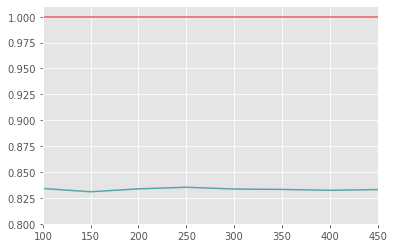

In [0]:
import matplotlib.pyplot as plt
plt.plot(param, valida, color='#58A4B0')
plt.plot(param, traina, color='#ED5A5A')
plt.xlim(100, 450)
plt.ylim(0.8, 1.01)
plt.show()


The accuracy didn't vary with the changed parameter, so we decided to keep our final best fit parameter at 400.
Next, we analysed the best fit model, by looking at the features and the weights they hold. 

In [0]:
#MOST IMPORTANT FEATURES
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
avg_reviews,0.154146
age,0.117783
star_trend,0.109996
sent_trend,0.108720
counter,0.063639
...,...
washington,0.000000
maricopa,0.000000
of,0.000000
boro,0.000000


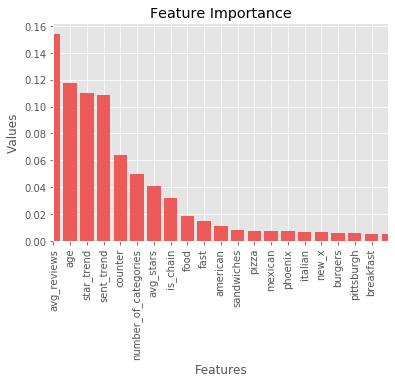

In [0]:
#BAR PLOT FOR THE MOST IMPORTANT WEIGHTS
featuresn=feature_importances.index.values.tolist()
featuresv=feature_importances['importance'].tolist()
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x_pos = [i for i in range(len(featuresn))]

plt.bar(x_pos, featuresv, color='#ED5A5A')
plt.xlabel("Features")
plt.ylabel("Values")
plt.title("Feature Importance")
plt.xlim(0, 20)
plt.xticks(x_pos[0:20], featuresn[0:20], rotation='vertical')


plt.show()

[[ 491 1665]
 [1043 3967]]




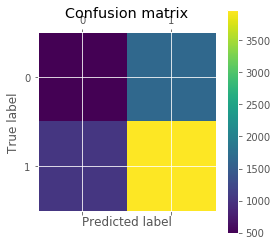

In [0]:
#PLOT CONFUSION MATRIX FOR THE BEST FIT
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('\n')
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Lastly, we did a final comparison between default Linera SVC, Logistic Regression and Regression Forest with the new parameters. 

In [0]:
#COMPARISON OF THE DEFAULT MODELS
frame=pd.DataFrame(columns=[' ','Logistic Regression', 'Linear SVC', 'Random Forest (default)'])
er=['Test Accuracy']
frame[' ']=er

In [0]:
#DEFAULT LOGISTIC REGRESSION
reg = LogisticRegression().fit(X_train, y_train)
log_predictions = reg.predict(X_test)
log_probs = reg.predict_proba(X_test)[:, 1]
frame['Logistic Regression']=reg.score(X_test, y_test)

In [0]:
#DEFAULT LINEAR SVC 
from sklearn.calibration import CalibratedClassifierCV
abc = LinearSVC(random_state=0, tol=1e-5)
abc.fit(X_train, y_train)
lin_predictions = abc.predict(X_test)
frame['Linear SVC']=abc.score(X_test, y_test)

abe = CalibratedClassifierCV(abc) 
abe.fit(X_train, y_train)
lin_probs = abe.predict_proba(X_test)[:, 1]

In [0]:
#BEST FIT
clf=RandomForestClassifier(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=400)
clf.fit(X_train,y_train)
clf.score(X_test, y_test)
rf_predictions = clf.predict(X_test)
rf_probs = clf.predict_proba(X_test)[:, 1]
frame['Random Forest (default)']=clf.score(X_test, y_test)

In [0]:
#comparison of error befor hyper-parameter tunning
frame

,,Logistic Regression,Linear SVC,Random Forest (default)
0,Test Accuracy,0.769048,0.763187,0.797516


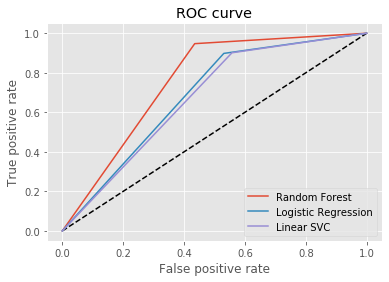

In [0]:
#PLOT THE ROC CURVE (after hyperparameter tuning for RF)
#random forest
rffpr, rftpr, rfthresholds = metrics.roc_curve(y_test, rf_predictions)
#logistic
lofpr, lotpr, lothresholds = metrics.roc_curve(y_test, log_predictions)
#linear
lifpr, litpr, lithresholds = metrics.roc_curve(y_test, lin_predictions)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rffpr, rftpr, label='Random Forest')
plt.plot(lofpr, lotpr, label='Logistic Regression')
plt.plot(lifpr, litpr, label='Linear SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Summary of Results**

After experimenting with a Linear SVC, Logistic Regression, and a Random Forest model, we selected the Random Forest model for continued experiments and hypertuned parameters through 5-fold cross validation. The test accuracy that we obtained using this optimal model is 83.06%.

The aim of our research was to explore what factors prospective restaurant owners should consider before making significant time and financial investment. It is interesting to note that the features with the most important weights with our optimal model are the features that we created ourselves. Thus, some of the factors that should be considered are obtaining a high number of average reviews per week, the positivity of the reviews over time, and the number of other restaurants in the area. Additionally, it is worth noting that in this particular test, the trend of star ratings over time is more important than the overall average star rating.   

   


#  **Discussion**

**Evaluation of Findings**

One of our biggest challenges came from the large size of the review data-the JSON file was 6GB! To process this large dataset, we used pickle to load and read the data in 10 chunks. However, our feature engineering using the review data still took quite a bit of time. We split the process and ran it concurrently on Google Colab, Jupyter Hub, and locally. However, in the future, we will look into using a data processing framework like PySpark.

Another challenge came from the uneven distribution of our data; most businesses are open, so we did not have a balance of closed and open businesses. In the future, we will do more research on finding better evaluation metrics than percent accuracy such as a Kappa coefficient.

Another challenge came from the nature of our data. Yelp dataset includes information of all types of businesses, and occasionally, there will be some restaurants that function also as other types of businesses (ex: IKEA or sports clubs), which meant meant that the reviews and ratings were not only the reflection of the restaurants but the overall business. In the future, we could either include this as a feature itself, or choose a dataset like, Opentable, Zomato and etc, that would only focus on restaurants.


**Further Directions**    
This project has a lot of potential in exploring other parameters for restaurant success. For instance, additional features could include comparing star trends and ratings to nearby restaurants within the same category or integrating real estate data. It would be also cool to use the Yelp Fusion API to determine whether restaurants are open in the year 2019 following the release of the dataset and compare the features created with the Yelp dataset to those created with other review aggregators like Google reviews.